# MINE 4201 - Laboratorio 2 - Filtrado por contenido

Los sistemas de recomendación basados en contenido filtran contenido basado en la representación de items y el perfil del usuario. En este laboratorio trabajaremos con un conjunto de datos del sitio web [LibraryThing](https://https://www.librarything.com/).


## Preparación del entorno
Instale las librerias que vamos a utilizar e importelas en el ambiente de ejecución

In [84]:
%pip install scikit-learn pandas seaborn --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [85]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV,HalvingRandomSearchCV
from sklearn.metrics import classification_report
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from pathlib import Path
from IPython.display import display,Markdown,clear_output
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support,mean_squared_error
from sklearn.pipeline import Pipeline




## Carga de archivos 

Copie el archivo del dataset en el entorno colab en la pestaña files (la carpeta en el menú de la izquierda), carguemos el csv en un dataframe de pandas y revisemos su contenido.

In [86]:
datasetPath = Path('./DB-BOOK-content.csv')
if not datasetPath.exists():
  raise ValueError('El archivo DB-BOOK-content.csv no fue encontrado en el path')
else:
  print("Los archivos han sido cargados")

Los archivos han sido cargados


In [87]:
df_dbbook=pd.read_csv(datasetPath, sep=';')
df_dbbook

,DBbook_userID,name,DBbook_ItemID,featureID,featureShortname,rate
0,1,"Contingency, Irony, and Solidarity",508,1066,/Category:1989_books,5
1,1,"Contingency, Irony, and Solidarity",508,2300,/Richard_Rorty,5
2,1,"Contingency, Irony, and Solidarity",508,2301,/Category:Works_about_Marcel_Proust,5
3,1,"Contingency, Irony, and Solidarity",508,2302,/Category:Books_by_Richard_Rorty,5
4,1,"Contingency, Irony, and Solidarity",508,2303,/Category:Books_about_irony,5
...,...,...,...,...,...,...
1439449,7255,The Catcher in the Rye,8010,3322,/Category:American_bildungsromans,3
1439450,7255,The Catcher in the Rye,8010,6746,/Category:1949_in_fiction,3
1439451,7255,The Catcher in the Rye,8010,9011,/J._D._Salinger,3
1439452,7255,The Catcher in the Rye,8010,10155,/Category:Novels_by_J._D._Salinger,3


Este dataset tiene un formato similar al que manejamos el taller pasado. Tiene una columna con el id del usuario, otra con el id del item y un rating. 

Cada rating esta presente varias veces, una por cada característica de los libros, revisemos por ejemplo las características del libro con ID 8010.

Se selecciona del dataframe las columnas name, featureID y featureShortname, la instruccion drop_duplicates nos deja solamente las columnas que no 

Nota: Para saber más de indexación de dataframes de pandas utilizando .loc hay una explicación en la [documentación](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html)



In [88]:
df_dbbook.loc[df_dbbook.DBbook_ItemID==8010,['DBbook_ItemID','name','featureID','featureShortname']].drop_duplicates()

,DBbook_ItemID,name,featureID,featureShortname
996,8010,The Catcher in the Rye,3,/Communication100033020
997,8010,The Catcher in the Rye,4,/Fiction106367107
998,8010,The Catcher in the Rye,5,/LiteraryComposition106364329
999,8010,The Catcher in the Rye,6,/Writing106362953
1000,8010,The Catcher in the Rye,7,/WrittenCommunication106349220
1001,8010,The Catcher in the Rye,11,/Novel106367879
1002,8010,The Catcher in the Rye,13,/Abstraction100002137
1003,8010,The Catcher in the Rye,228,/DebutNovels
1004,8010,The Catcher in the Rye,233,/Category:Debut_novels
1005,8010,The Catcher in the Rye,277,"/Category:Little,_Brown_and_Company_books"


Cada libro tiene features fueron extraidos de [DBpedia](https://wiki.dbpedia.org/). Dbpedia es una iniciativa para construir una representación de conceptos y relaciones mediante ontologías utilizando la información depositada en wikipedia. Más adelante vamos a utilizar DBPedia para otros talleres que aprovechan la información de la ontología de DBPedia, por ahora lo que tenemos es una representación de conjunto de palabras (o conceptos) para describir un item.  

## Creación de matriz documento-termino

En las siguientes líneas vamos a crear la matriz documento término, el primer paso es obtener en un dataframe los libros, los conceptos, y  los conceptos únicos por libro.

In [89]:
df_libros=df_dbbook.loc[:,['DBbook_ItemID','name']].drop_duplicates()
df_libros

,DBbook_ItemID,name
0,508,"Contingency, Irony, and Solidarity"
8,802,The Solitaire Mystery
26,889,Wise Blood
49,1367,The Bell Jar
72,1736,The Structure of Scientific Revolutions
...,...,...
1434966,2860,Practical Magic
1436627,3838,Destiny: A Chronicle of Deaths Foretold
1437751,5779,The Road to Omaha
1438719,3485,Kamikaze Girls


In [90]:
df_conceptos=df_dbbook.loc[:,['featureID','featureShortname']].drop_duplicates()
df_conceptos

,featureID,featureShortname
0,1066,/Category:1989_books
1,2300,/Richard_Rorty
2,2301,/Category:Works_about_Marcel_Proust
3,2302,/Category:Books_by_Richard_Rorty
4,2303,/Category:Books_about_irony
...,...,...
1438749,8790,/Category:Adventure_comedy_films
1438750,8791,/Category:Fantasy-comedy_films
1438752,8793,/Category:2004_Japanese_films
1438766,9393,/NovelsByDavidDrake


In [91]:
df_libros_concepto=df_dbbook.loc[:,['DBbook_ItemID','name','featureID','featureShortname']].drop_duplicates()
df_libros_concepto

,DBbook_ItemID,name,featureID,featureShortname
0,508,"Contingency, Irony, and Solidarity",1066,/Category:1989_books
1,508,"Contingency, Irony, and Solidarity",2300,/Richard_Rorty
2,508,"Contingency, Irony, and Solidarity",2301,/Category:Works_about_Marcel_Proust
3,508,"Contingency, Irony, and Solidarity",2302,/Category:Books_by_Richard_Rorty
4,508,"Contingency, Irony, and Solidarity",2303,/Category:Books_about_irony
...,...,...,...,...
1438763,3963,Queen of Demons,790,/1998Novels
1438764,3963,Queen of Demons,793,/Category:1998_novels
1438765,3963,Queen of Demons,4006,/David_Drake
1438766,3963,Queen of Demons,9393,/NovelsByDavidDrake


Se quiere obtener una martiz que tenga como filas cada uno de los libros, y como columnas cada uno de los conceptos, y en cada coordenada un 1 si esta presente el concepto y 0 de lo contrario. A esta operación se le conoce como pivot de una tabla.

La función [pivot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html) toma tres parámetros: la columna del dataframe original que va a tomar el índice de las filas del nuevo dataframe (index), la columna del dataframe original mediante la cual se van a generar las columnas (columns) y values los valores con los cuales se va a llenar el dataframe, en este caso  vamos a dejar momentaneamente el id del feature para indicar que existe.

Finalmente aplicamos la función [applymap](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.applymap.html) para modificar uno a uno los elementos de la matriz



In [92]:
df_matriz_libros_concepto=df_libros_concepto[['DBbook_ItemID','featureID']].drop_duplicates().pivot(index='DBbook_ItemID', columns='featureID', values='featureID')
#La función astype int8 nos permite reducir el uso de memoria al dejar matrices de enteros
df_matriz_libros_concepto=df_matriz_libros_concepto.applymap(np.sign).fillna(0).astype('int8')
df_matriz_libros_concepto

featureID,1,2,3,4,5,6,7,8,9,10,...,13992,13993,13994,13995,13996,13997,13998,13999,14000,14001
DBbook_ItemID,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8164,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8166,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8167,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
df_matriz_libros_concepto.shape

(6164, 12246)

En la siguiente celda se está aplicando la función [sumatoria](https://www.geeksforgeeks.org/python-pandas-dataframe-sum/) por eje al dataframe anterior, por defecto el eje es 0, por lo que generará una Serie (vector) del tamaño de las columnas y por cada columna calculará la sumatoria

In [94]:
help(np.sum)

Help on function sum in module numpy:

sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)
    Sum of array elements over a given axis.
    
    Parameters
    ----------
    a : array_like
        Elements to sum.
    axis : None or int or tuple of ints, optional
        Axis or axes along which a sum is performed.  The default,
        axis=None, will sum all of the elements of the input array.  If
        axis is negative it counts from the last to the first axis.
    
        .. versionadded:: 1.7.0
    
        If axis is a tuple of ints, a sum is performed on all of the axes
        specified in the tuple instead of a single axis or all the axes as
        before.
    dtype : dtype, optional
        The type of the returned array and of the accumulator in which the
        elements are summed.  The dtype of `a` is used by default unless `a`
        has an integer dtype of less precision than the default platform
        integer.  In 

In [95]:
series_suma=df_matriz_libros_concepto.sum()
series_suma

featureID
1           6
2         225
3        2766
4        2672
5        2674
         ... 
13997       1
13998       1
13999       1
14000       1
14001       1
Length: 12246, dtype: int64

El objeto series_suma no es un dataframe sino un objeto tipo Series, que es un arreglo. Un dataframe puede ser visto como una concatenación de varios objetos de tipo Series

In [96]:
type(series_suma)

pandas.core.series.Series

In [97]:
series_suma

featureID
1           6
2         225
3        2766
4        2672
5        2674
         ... 
13997       1
13998       1
13999       1
14000       1
14001       1
Length: 12246, dtype: int64

**Interprete las siguientes figuras y diga qué quieren decir en términos del número de items y de características asignadas a los items**

<AxesSubplot: >

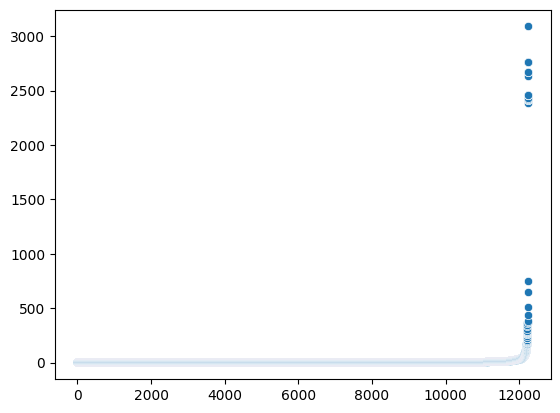

In [98]:
sns.scatterplot(x=range(0,len(series_suma)) ,y=series_suma.sort_values())

In [99]:
series_suma.describe()

count    12246.000000
mean         8.394823
std         95.183540
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       3089.000000
dtype: float64

In [100]:
series_suma_2=df_matriz_libros_concepto.sum(axis=1)
series_suma_2

DBbook_ItemID
1       23
2       20
3       36
5       23
7       22
        ..
8164    23
8166    13
8167    17
8168    22
8169    25
Length: 6164, dtype: int64

<AxesSubplot: >

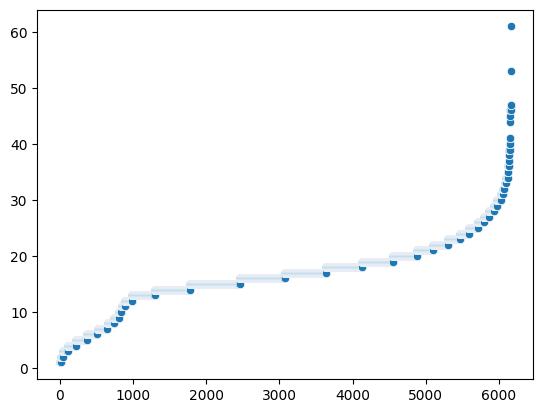

In [101]:
sns.scatterplot(x=range(0,len(series_suma_2)) ,y=series_suma_2.sort_values() )

# Cálculo de matriz tf-idf

La matriz df_matriz_libros_concepto hasta el momento tiene en cada coordenada la presencia o ausencia de la característica que describe el atributo, este sería el término $\text{tf}$ de la siguiente fórmula donde $i$ es un término o palabra y $d$ es un documento.

$\text{tfidf}_{i,d} = \text{tf}_{i,d} \cdot \text{idf}_{i}$

El Inverse Document Frequency esta definido como:

$\text{idf}_{i,d} = \log \frac{N}{\text{df}_{i}}$

Donde $\text{df}_{t}$ es el número de documentos en los que aparece el término $i$ y N el número total de documentos 



En python es posible operar vectores con escalares directamente, gracias a que por debajo python genera operaciones entre arreglos cuando operamos con un escalar mediante la operación de [broadcasting](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html) Por ejemplo, el anterior arreglo se puede dividir entre 6, por debajo python genera un arreglo del mismo tamaño y realiza la operación elemento a elemento

In [102]:
series_suma/6

featureID
1          1.000000
2         37.500000
3        461.000000
4        445.333333
5        445.666667
            ...    
13997      0.166667
13998      0.166667
13999      0.166667
14000      0.166667
14001      0.166667
Length: 12246, dtype: float64

En las siguientes celdas, cree un objeto tipo series llamado df_idf, que contiene el IDF de cada atributo. Puede utilizar la función [np.log2](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log2.html) de numpy

In [103]:

df_idf = np.log2(len(series_suma) / series_suma)
df_idf

featureID
1        10.995060
2         5.766242
3         2.146438
4         2.196319
5         2.195239
           ...    
13997    13.580023
13998    13.580023
13999    13.580023
14000    13.580023
14001    13.580023
Length: 12246, dtype: float64

Si df_idf fue calculado correctamente, la siguiente instrucción multiplicará cada fila del dataframe elemento por elemento (element-wise) por la serie que contiene el IDF

In [104]:
df_matriz_tf_idf=df_matriz_libros_concepto.multiply(df_idf, axis=1)
df_matriz_tf_idf

featureID,1,2,3,4,5,6,7,8,9,10,...,13992,13993,13994,13995,13996,13997,13998,13999,14000,14001
DBbook_ItemID,,,,,,,,,,,,,,,,,,,,,
1,10.99506,5.766242,2.146438,2.196319,2.195239,2.149048,2.149048,7.798663,8.025434,10.580023,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,10.99506,5.766242,2.146438,2.196319,2.195239,2.149048,2.149048,0.000000,8.025434,10.580023,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.000000,2.146438,2.196319,2.195239,2.149048,2.149048,7.798663,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
5,0.00000,0.000000,2.146438,2.196319,2.195239,2.149048,2.149048,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
7,0.00000,0.000000,2.146438,2.196319,2.195239,2.149048,2.149048,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8164,0.00000,0.000000,2.146438,2.196319,2.195239,2.149048,2.149048,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
8166,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
8167,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


En el siguiente mapa de calor se observa el tf_idf de los items representados en las 300 características con mayor frecuencia.

In [105]:
df_matriz_tf_idf.loc[:,series_suma.nlargest(300).index]

featureID,13,3,6,7,5,4,11,65,59,60,...,1637,2214,2227,2228,2230,2702,447,496,1299,1507
DBbook_ItemID,,,,,,,,,,,,,,,,,,,,,
1,1.987099,2.146438,2.149048,2.149048,2.195239,2.196319,2.217531,0.00000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.987099,2.146438,2.149048,2.149048,2.195239,2.196319,2.217531,0.00000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.987099,2.146438,2.149048,2.149048,2.195239,2.196319,2.217531,0.00000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.987099,2.146438,2.149048,2.149048,2.195239,2.196319,2.217531,0.00000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.987099,2.146438,2.149048,2.149048,2.195239,2.196319,2.217531,0.00000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8164,1.987099,2.146438,2.149048,2.149048,2.195239,2.196319,2.217531,0.00000,0.000000,0.000000,...,8.580023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.31558,2.316167,2.316167,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.31558,2.316167,2.316167,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
%pip install tabulate --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [107]:
#plt.rcParams["figure.figsize"] = (15,15)
# sns.heatmap(df_matriz_tf_idf.loc[:,series_suma.nlargest(300).index],cmap="Blues", vmin=0)
display(Markdown("**5 Términos más frecuentes**"))
display(Markdown(series_suma.nlargest(30).to_markdown()))
display(Markdown("-"*3))

display(Markdown("**5 Términos más frecuentes según el Heatmap**"))
display(
    Markdown(series_suma[series_suma.index.isin([13, 4, 58, 62])].to_markdown()))

print(f"total books: {len(df_libros)}")

**5 Términos más frecuentes**

|   featureID |    0 |
|------------:|-----:|
|          13 | 3089 |
|           3 | 2766 |
|           6 | 2761 |
|           7 | 2761 |
|           5 | 2674 |
|           4 | 2672 |
|          11 | 2633 |
|          65 | 2460 |
|          59 | 2459 |
|          60 | 2459 |
|          58 | 2430 |
|          64 | 2425 |
|          66 | 2425 |
|          63 | 2415 |
|          67 | 2415 |
|          62 | 2389 |
|          30 |  752 |
|         132 |  645 |
|          92 |  509 |
|         295 |  436 |
|         298 |  379 |
|         294 |  376 |
|         556 |  362 |
|          86 |  343 |
|          51 |  336 |
|         463 |  309 |
|         296 |  287 |
|        1289 |  286 |
|          56 |  284 |
|         297 |  281 |

---

**5 Términos más frecuentes según el Heatmap**

|   featureID |    0 |
|------------:|-----:|
|           4 | 2672 |
|          13 | 3089 |
|          58 | 2430 |
|          62 | 2389 |

total books: 6164


**¿Qué puede interpretar sobre la figura anterior? 
Encuentre los nombres de las características más frecuentes**

In [108]:
df_conceptos[df_conceptos["featureID"].isin(series_suma.nlargest(10).index)]


,featureID,featureShortname
8,3,/Communication100033020
9,4,/Fiction106367107
10,5,/LiteraryComposition106364329
11,6,/Writing106362953
12,7,/WrittenCommunication106349220
13,11,/Novel106367879
14,13,/Abstraction100002137
50,59,/Object100002684
51,60,/Whole100003553
55,65,/PhysicalEntity100001930


# Selección de características

Una vez realizado el proceso de indexamiento, se puede realizar el proceso de selección de características. 

En este momento contamos con más de 12 mil conceptos. ¿Con cuántos vale la pena crear los modelos de filtrado?

El paso más simple es filtrar las características con baja frecuencia dentro del dataset

In [109]:
series_suma.describe()

count    12246.000000
mean         8.394823
std         95.183540
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       3089.000000
dtype: float64

**¿Qué puede decir sobre la distribución de frecuencia de las características en los items? ¿Vale la pena tener todas las características que tenemos actualmente?**

.
**Retire de la matriz df_matrix_tf_idf las columnas que representan a los items que tienen menos de 3 items asociados**

In [110]:
# Se filtra la serie por aquellos que tienen al menos 3 
series_suma[series_suma>=3]

featureID
1           6
2         225
3        2766
4        2672
5        2674
         ... 
13204       5
13549       3
13627       3
13920       5
13922       5
Length: 3894, dtype: int64

In [111]:
series_suma[series_suma >= 3].describe()

count    3894.000000
mean       23.762455
std       167.780183
min         3.000000
25%         3.000000
50%         5.000000
75%        11.000000
max      3089.000000
dtype: float64

In [112]:
df_matriz_tf_idf=df_matriz_tf_idf.loc[:,series_suma[series_suma>=3].index]

In [113]:
df_matriz_tf_idf

featureID,1,2,3,4,5,6,7,8,9,10,...,12919,12995,12997,13045,13046,13204,13549,13627,13920,13922
DBbook_ItemID,,,,,,,,,,,,,,,,,,,,,
1,10.99506,5.766242,2.146438,2.196319,2.195239,2.149048,2.149048,7.798663,8.025434,10.580023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.99506,5.766242,2.146438,2.196319,2.195239,2.149048,2.149048,0.000000,8.025434,10.580023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.000000,2.146438,2.196319,2.195239,2.149048,2.149048,7.798663,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.00000,0.000000,2.146438,2.196319,2.195239,2.149048,2.149048,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.00000,0.000000,2.146438,2.196319,2.195239,2.149048,2.149048,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8164,0.00000,0.000000,2.146438,2.196319,2.195239,2.149048,2.149048,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8166,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8167,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Para las siguientes estrategias de selección de características, tenemos que aplicar técnicas supervisadas (que conocen la clase a predecir o lo que se quiere pronosticar), para esto tenemos que retomar nuestro dataset original de interacciones entre usuarios e items para asignar la etiqueta (le gustó/ no le gustó)

In [114]:
# Recordemos como es el dataset original.
df_dbbook.head(20)

,DBbook_userID,name,DBbook_ItemID,featureID,featureShortname,rate
0,1,"Contingency, Irony, and Solidarity",508,1066,/Category:1989_books,5
1,1,"Contingency, Irony, and Solidarity",508,2300,/Richard_Rorty,5
2,1,"Contingency, Irony, and Solidarity",508,2301,/Category:Works_about_Marcel_Proust,5
3,1,"Contingency, Irony, and Solidarity",508,2302,/Category:Books_by_Richard_Rorty,5
4,1,"Contingency, Irony, and Solidarity",508,2303,/Category:Books_about_irony,5
5,1,"Contingency, Irony, and Solidarity",508,2304,/Category:Cambridge_University_Press_books,5
6,1,"Contingency, Irony, and Solidarity",508,2305,/Category:Cognitive_science_literature,5
7,1,"Contingency, Irony, and Solidarity",508,2306,/Category:Ethics_books,5
8,1,The Solitaire Mystery,802,3,/Communication100033020,4
9,1,The Solitaire Mystery,802,4,/Fiction106367107,4


Creemos un dataframe para crear un dataset de un sistema de recomendación como el visto en el laboratorio pasado (una única interacción de tipo usuario, item y rating)

In [115]:
df_all_interactions=df_dbbook[['DBbook_userID','DBbook_ItemID','rate']].drop_duplicates()
df_all_interactions

,DBbook_userID,DBbook_ItemID,rate
0,1,508,5
8,1,802,4
26,1,889,5
49,1,1367,5
72,1,1736,5
...,...,...,...
1439370,7255,6871,3
1439392,7255,7227,3
1439401,7255,7471,3
1439416,7255,7472,4


Para asignar una clase, se binarizan los ratings. Una regla simple es calcular el rating promedio por persona. Todo lo que esté por debajo del promedio se clasifica como no le gusta, igual o por encima es si le gusta.

In [116]:
df_user_mean=df_all_interactions.groupby('DBbook_userID')['rate'].mean().reset_index()
df_user_mean.columns=['DBbook_userID','mean']
df_user_mean

,DBbook_userID,mean
0,1,4.545455
1,2,4.250000
2,3,3.684211
3,4,3.571429
4,5,4.181818
...,...,...
6176,7251,3.800000
6177,7252,3.230769
6178,7253,4.000000
6179,7254,4.222222


**Realice un merge entre df_all_interactions y df_user_mean, asignando su resultado a df_all_interactions.
Cree una nueva columna en el dataframe df_all_interactions llamada 'class' con True si el rating del usuario es mayor o igual a su promedio**

[Documentación pandas merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html)

[Tutorial creación de columnas a partir del valor de otras](https://thispointer.com/python-pandas-how-to-add-new-columns-in-a-dataframe-using-or-dataframe-assign/)

In [117]:

df_all_interactions=df_all_interactions.merge(df_user_mean,on="DBbook_userID")

In [118]:

df_all_interactions['class'] = df_all_interactions["rate"] > df_all_interactions["mean"]


In [119]:
df_all_interactions

,DBbook_userID,DBbook_ItemID,rate,mean,class
0,1,508,5,4.545455,True
1,1,802,4,4.545455,False
2,1,889,5,4.545455,True
3,1,1367,5,4.545455,True
4,1,1736,5,4.545455,True
...,...,...,...,...,...
75537,7255,6871,3,3.166667,False
75538,7255,7227,3,3.166667,False
75539,7255,7471,3,3.166667,False
75540,7255,7472,4,3.166667,True


Por último, se procede a partir el dataset en entrenamiento y test. Se utiliza de la librería sklearn la función [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

Esta recibe como parámetro el dataset a partir, el porcentaje para test y un parámetro que indica la variable por la cual estratificar la partición, en este caso quisieramos que las interacciones en test sean de usuarios que vimos en train, por lo tanto se deja estratificado por usuario.

In [120]:
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
    Split arrays or matrices into random train and test subsets.
    
    Quick utility that wraps input validation,
    ``next(ShuffleSplit().split(X, y))``, and application to input data
    into a single call for splitting (and optionally subsampling) data into a
    one-liner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to

In [121]:
#Para garantizar reproducibilidad en resultados
seed = 42069
# random.seed(seed)
# np.random.seed(seed)
df_all_interactions_train, df_all_interactions_test =train_test_split(df_all_interactions, test_size=0.2, stratify=df_all_interactions['DBbook_userID'],random_state=seed)

In [122]:
df_all_interactions_train

,DBbook_userID,DBbook_ItemID,rate,mean,class
69030,6623,5163,4,4.400000,False
68630,6581,5696,4,3.785714,True
43901,4220,5736,3,3.421053,False
5421,517,4627,5,3.428571,True
24474,2332,2742,4,3.666667,True
...,...,...,...,...,...
59547,5707,1007,4,3.800000,True
58429,5600,6971,4,3.818182,True
35051,3349,5546,5,4.700000,True
11260,1069,4718,5,3.454545,True


In [123]:
df_all_interactions_test

,DBbook_userID,DBbook_ItemID,rate,mean,class
5095,484,4799,4,3.500000,True
10733,1021,5439,4,3.583333,True
148,13,458,4,3.500000,True
53494,5139,6700,4,4.125000,False
8184,788,5683,5,3.789474,True
...,...,...,...,...,...
11105,1055,159,4,4.461538,False
28346,2715,1888,4,4.166667,False
10776,1025,6703,2,2.400000,False
28770,2757,6880,5,3.958333,True


In [124]:
df_all_interactions_train.DBbook_userID.value_counts()

1114    19
188     19
4622    19
3490    19
189     19
        ..
1584     4
5718     4
5129     4
6171     4
6188     4
Name: DBbook_userID, Length: 6181, dtype: int64

In [125]:
df_all_interactions_test.DBbook_userID.value_counts()

5929    5
68      5
2429    5
2682    5
1754    5
       ..
1983    1
6478    1
2483    1
174     1
2715    1
Name: DBbook_userID, Length: 6181, dtype: int64

In [126]:
df_conteos_usuario_train_test=pd.concat([df_all_interactions_train.DBbook_userID.value_counts(),df_all_interactions_test.DBbook_userID.value_counts()],axis=1)
df_conteos_usuario_train_test.columns=['train_count','test_count']

In [127]:
df_conteos_usuario_train_test

,train_count,test_count
1114,19,5
188,19,5
4622,19,5
3490,19,5
189,19,5
...,...,...
1584,4,1
5718,4,1
5129,4,1
6171,4,1


In [128]:
df_conteos_usuario_train_test.nlargest(500,'test_count')

,train_count,test_count
1114,19,5
188,19,5
4622,19,5
3490,19,5
189,19,5
...,...,...
830,18,4
1980,18,4
4501,18,4
4941,18,4


**Chi-cuadrado**

La selección de características mediante la prueba [chi-cuadrado](https://en.wikipedia.org/wiki/Chi-squared_test) nos dice si la diferencia observada entre las frecuencias de co-ocurrencia de dos variables es significativa. La idea es seleccionar características que más ayuden a discriminar la clase objetivo observando la frecuencia en la que ocurren juntas. 

La librería sklearn permite identificar la importancia de cada una de las variables utilizando el método [chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html)

In [129]:
help(chi2)

Help on function chi2 in module sklearn.feature_selection._univariate_selection:

chi2(X, y)
    Compute chi-squared stats between each non-negative feature and class.
    
    This score can be used to select the `n_features` features with the
    highest values for the test chi-squared statistic from X, which must
    contain only **non-negative features** such as booleans or frequencies
    (e.g., term counts in document classification), relative to the classes.
    
    Recall that the chi-square test measures dependence between stochastic
    variables, so using this function "weeds out" the features that are the
    most likely to be independent of class and therefore irrelevant for
    classification.
    
    Read more in the :ref:`User Guide <univariate_feature_selection>`.
    
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Sample vectors.
    
    y : array-like of shape (n_samples,)
        Target vector (class lab

En filtrado por contenido, se arma un modelo por usuario. Por ahora vamos a escoger las características más importantes para el primer usuario del dataset de test

In [130]:
#Debería dar 1124
primer_usuario_id=df_all_interactions_test.iloc[0]['DBbook_userID']
primer_usuario_id

484

Obtengamos los ids de los items con los que ha interactuado y su opinion

In [131]:
df_temporal_usuario=df_all_interactions_train.loc[df_all_interactions_train.DBbook_userID==1124,['DBbook_ItemID','class']]
df_temporal_usuario

,DBbook_ItemID,class
11940,1970,True
11946,4799,False
11939,1578,True
11945,4614,False
11938,1391,False
11941,3006,True
11937,1292,False
11944,4108,False
11943,4103,True


Peguemos a este dataframe la representación vectorial de tf_idf por el id del item, en la matriz es el índice de las filas

In [132]:
df_temporal_usuario=df_temporal_usuario.merge(df_matriz_tf_idf, how='left', left_on='DBbook_ItemID', right_index=True)
df_temporal_usuario

,DBbook_ItemID,class,1,2,3,4,5,6,7,8,...,12919,12995,12997,13045,13046,13204,13549,13627,13920,13922
11940,1970,True,0.0,5.766242,2.146438,2.196319,2.195239,2.149048,2.149048,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11946,4799,False,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11939,1578,True,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11945,4614,False,0.0,0.000000,2.146438,2.196319,2.195239,2.149048,2.149048,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11938,1391,False,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11941,3006,True,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11937,1292,False,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11944,4108,False,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11943,4103,True,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Este dataframe representa los datos de entrenamiento del modelo para predicción de una clase binaria (class True es le gusta, class False es no le gusta)

In [133]:
#vamos a indexar solamente las columnas que son características, la prueba chi2 lo compara todas las características contra la clase objetivo
features=df_matriz_tf_idf.columns

In [134]:
pesos_chi2, pval= chi2(df_temporal_usuario[features],df_temporal_usuario['class'])

In [135]:
#La prueba puede arrojar nan
pesos_chi2

array([       nan, 7.20780222, 0.05366094, ...,        nan,        nan,
              nan])

In [136]:
pval

array([       nan, 0.00725873, 0.81681118, ...,        nan,        nan,
              nan])

In [137]:
# LLenamos con peso 0 los que no se pudieron calcular
pesos_chi2=np.nan_to_num(pesos_chi2)
pesos_chi2

array([0.        , 7.20780222, 0.05366094, ..., 0.        , 0.        ,
       0.        ])

Se crea una máscara de indexación con los valores que son positivos según la prueba

In [138]:
pesos_chi2_mask=pesos_chi2>0

In [139]:
pesos_chi2_mask

array([False,  True,  True, ..., False, False, False])

In [140]:
features[pesos_chi2_mask]

Int64Index([   2,    3,    4,    5,    6,    7,   11,   13,   22,   30,   56,
              58,   59,   60,   62,   63,   64,   65,   66,   67,   86,  116,
             117,  127,  132,  168,  173,  186,  188,  198,  215,  241,  242,
             290,  292,  294,  295,  296,  297,  298,  372,  377,  432,  436,
             437,  438,  439,  463,  464,  474,  490,  499,  504,  523,  528,
             579,  582,  725,  778,  968,  971,  972,  978, 1040, 1044, 1077,
            1289, 1301, 1415, 1731, 1733, 1833, 1887, 1952, 1956, 2211, 2213,
            2288, 2299, 2617, 2621, 3001, 3252, 3253, 4367, 4368, 4723, 4860,
            5057, 6095, 6096, 6097, 6986, 8656, 8658, 8659],
           dtype='int64', name='featureID')

El siguiente sería el resultado, se recortaron las columnas de pesos del usuario, dejando 119 features.

In [141]:
df_temporal_usuario.loc[:,features[pesos_chi2_mask]]

featureID,2,3,4,5,6,7,11,13,22,30,...,4723,4860,5057,6095,6096,6097,6986,8656,8658,8659
11940,5.766242,2.146438,2.196319,2.195239,2.149048,2.149048,2.217531,1.987099,8.45074,0.000000,...,11.258095,0.00000,9.99506,11.99506,11.99506,11.99506,0.00000,0.000000,0.000000,0.000000
11946,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000
11939,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,10.99506,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000
11945,0.000000,2.146438,2.196319,2.195239,2.149048,2.149048,2.217531,1.987099,0.00000,0.000000,...,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000
11938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000
11941,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.987099,0.00000,0.000000,...,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000
11937,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000
11944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,4.025434,...,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,10.580023,10.772668,10.772668
11943,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,10.99506,0.000000,0.000000,0.000000


In [142]:
del df_temporal_usuario

**Complete el código de la siguiente celda, el objetivo es crear un diccionario donde la llave es el id del usuario y el valor es un arreglo con los features seleccionados para el usuario**

El proceso que implementamos no esta optimizado, por lo que vamos a armar el modelo solamente para los 500 usuarios con más ratings en el dataset de test.


In [143]:
diccionario_usuarios_features={}
# 500 usuarios con más ratings en test
unique_users_test=df_conteos_usuario_train_test.nlargest(500,'test_count').index
i=0
print(unique_users_test.shape)
for user in unique_users_test:
  if not user in diccionario_usuarios_features:
    df_temporal_usuario=df_all_interactions_train.loc[df_all_interactions_train.DBbook_userID==user,['DBbook_ItemID','class']]
    
    df_temporal_usuario=df_temporal_usuario.merge(df_matriz_tf_idf, how='left', left_on='DBbook_ItemID', right_index=True)
   
    pesos_chi2, pval= chi2(df_temporal_usuario[features],df_temporal_usuario['class'])
    pesos_chi2=np.nan_to_num(pesos_chi2)
    pesos_chi2_mask=pesos_chi2>0
    features_usuario=features[pesos_chi2_mask]
    diccionario_usuarios_features[user]=features_usuario
    i=i+1
    if i%50==0:
      print(i)  
    del df_temporal_usuario


(500,)
50
100
150
200
250
300
350
400
450
500


In [144]:
len(diccionario_usuarios_features)

500

In [145]:
diccionario_usuarios_features.keys()

dict_keys([1114, 188, 4622, 3490, 189, 2262, 2172, 2689, 2288, 3255, 5278, 3879, 5137, 5569, 3602, 2345, 2490, 1728, 921, 4984, 5564, 6988, 4542, 6627, 5573, 4234, 3219, 3416, 2097, 734, 6366, 2107, 6585, 2852, 3342, 4500, 6084, 1176, 3703, 2159, 4987, 4764, 5261, 6167, 1343, 9, 2914, 2891, 2230, 5017, 1019, 2678, 7248, 6828, 3639, 1722, 6873, 872, 4628, 2877, 627, 209, 3484, 664, 2313, 1206, 4926, 2682, 5486, 6134, 2258, 5698, 4562, 6546, 2160, 5727, 4232, 6387, 248, 4619, 6432, 5931, 509, 1512, 4714, 4242, 774, 2812, 2185, 2757, 1955, 1247, 1715, 5688, 4627, 1084, 23, 511, 118, 1076, 2041, 689, 409, 4466, 4616, 4908, 3839, 430, 5338, 2643, 4185, 2474, 581, 4040, 6715, 4701, 2539, 5591, 6694, 1660, 2137, 4469, 6219, 1609, 68, 254, 158, 4192, 1021, 1934, 6562, 643, 3322, 1690, 6123, 2881, 3083, 1214, 938, 5951, 321, 3800, 6880, 351, 1563, 7068, 6168, 2455, 6333, 6556, 3539, 3852, 1549, 3957, 2610, 4124, 676, 1541, 6335, 7215, 5186, 3824, 2089, 3799, 5905, 1783, 4425, 1726, 4277, 107, 6

Otro criterio que puede ser usado es [Mutual Information](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif) 

# Modelo de recomendación y evaluación

Una vez seleccionadas las características por usuario, se puede usar el dataset de entrenamiento para aprender un modelo de clasificación binaria y probarlo sobre test.

Uno de los modelos que puede ser utilizado es el [clasificador por vecinos más cercanos](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).

Cada usuario tiene unas instancias representadas en un espacio vectorial del tamaño de las características seleccionadas anteriormente. Para una nueva instancia (predicción) se mira cuáles son los k vecinos más cercanos a ese dato nuevo y se predice la clase mayoritaria dentro del grupo de los vecinos. Observe el siguiente ejemplo. 

In [146]:
%%html
<iframe src="https://es.wikipedia.org/wiki/K_vecinos_m%C3%A1s_pr%C3%B3ximos#/media/Archivo:KnnClassification.svg" width="1200" height="600"></iframe>

Tomemos como ejemplo el usuario 679, armemos su conjunto de entrenamiento. Note que se estan seleccionando solamente los features calculados en el punto anterior

In [147]:
selected_userid=1114
features_usuario_userid = diccionario_usuarios_features[selected_userid]
df_temporal_usuario_train = df_all_interactions_train.loc[df_all_interactions_train.DBbook_userID == selected_userid, [
    'DBbook_ItemID', 'class']]
df_temporal_usuario_train=df_temporal_usuario_train.merge(df_matriz_tf_idf[features_usuario_userid], how='left', left_on='DBbook_ItemID', right_index=True)
df_temporal_usuario_train

,DBbook_ItemID,class,2,3,4,5,6,7,11,12,...,6077,6351,6353,7071,7075,7076,7927,8070,9936,11705
11823,5942,False,0.000000,2.146438,2.196319,2.195239,2.149048,2.149048,2.217531,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,11.99506
11815,3699,False,5.766242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000
11820,5081,True,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,10.580023,0.00000,0.00000
11834,7680,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000
11828,7125,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000
11817,4155,False,0.000000,2.146438,2.196319,2.195239,2.149048,2.149048,2.217531,7.798663,...,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,10.99506,0.000000,0.00000,0.00000
11812,137,True,0.000000,2.146438,2.196319,2.195239,2.149048,2.149048,2.217531,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000
11829,7126,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000
11824,6160,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,11.99506,0.00000
11813,139,True,0.000000,2.146438,2.196319,2.195239,2.149048,2.149048,2.217531,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000


Armamos de igual forma el conjunto de test

In [148]:
df_temporal_usuario_test = df_all_interactions_test.loc[df_all_interactions_test.DBbook_userID == selected_userid, [
    'DBbook_ItemID', 'class']]
df_temporal_usuario_test=df_temporal_usuario_test.merge(df_matriz_tf_idf[features_usuario_userid], how='left', left_on='DBbook_ItemID', right_index=True)
df_temporal_usuario_test


,DBbook_ItemID,class,2,3,4,5,6,7,11,12,...,6077,6351,6353,7071,7075,7076,7927,8070,9936,11705
11832,7678,False,0.0,2.146438,2.196319,2.195239,2.149048,2.149048,2.217531,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11822,5438,False,0.0,2.146438,2.196319,2.195239,2.149048,2.149048,2.217531,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11819,4360,False,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11814,1979,True,0.0,2.146438,2.196319,2.195239,2.149048,2.149048,2.217531,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11830,7541,True,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Utilizaremos la clase [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) de scikit-learn para hacer la predicción de los datos del conjunto de test. El modelo tiene 3 métodos principales. El constructor permite inicializar el k a usar, la métrica entre otros; fit sirve para darle los datos de entrenamiento base al modelo; y predict para predecir los datos que se le pasan.

In [149]:
#Con esta configuración se utilizan los 3 vecinos más cercanos, con distancia euclidiana
knn_clasif=KNeighborsClassifier(3)

In [150]:
# Fit recibe la matriz de entrenamiento y la clase objetivo
knn_clasif.fit(df_temporal_usuario_train[features_usuario_userid], df_temporal_usuario_train['class'])

KNeighborsClassifier(n_neighbors=3)

In [151]:
# llamamos predict sobre  los test , creando una nueva columna en el dataframe de test
df_temporal_usuario_test['predict']=knn_clasif.predict(df_temporal_usuario_test[features_usuario_userid])

In [152]:
df_temporal_usuario_test[['DBbook_ItemID','class','predict']].merge(df_libros, how='left', on='DBbook_ItemID')

,DBbook_ItemID,class,predict,name
0,7678,False,False,The Testament
1,5438,False,True,The Bonesetter's Daughter
2,4360,False,True,A Great and Terrible Beauty
3,1979,True,True,Becoming Madame Mao
4,7541,True,False,Wicked: The Life and Times of the Wicked Witch...


**En las siguientes celdas realice hipótesis sobre por qué falló la clasificación para estos items y por qué funcionó para los otros, revise los conceptos seleccionados para el usuario y los asociados a los items**

In [153]:
features_usuario = df_matriz_tf_idf[features_usuario_userid].reset_index()
features_usuario


featureID,DBbook_ItemID,2,3,4,5,6,7,11,12,13,...,6077,6351,6353,7071,7075,7076,7927,8070,9936,11705
0,1,5.766242,2.146438,2.196319,2.195239,2.149048,2.149048,2.217531,7.798663,1.987099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,5.766242,2.146438,2.196319,2.195239,2.149048,2.149048,2.217531,7.798663,1.987099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.000000,2.146438,2.196319,2.195239,2.149048,2.149048,2.217531,0.000000,1.987099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,0.000000,2.146438,2.196319,2.195239,2.149048,2.149048,2.217531,0.000000,1.987099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0.000000,2.146438,2.196319,2.195239,2.149048,2.149048,2.217531,0.000000,1.987099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6159,8164,0.000000,2.146438,2.196319,2.195239,2.149048,2.149048,2.217531,0.000000,1.987099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6160,8166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6161,8167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6162,8168,0.000000,2.146438,2.196319,2.195239,2.149048,2.149048,2.217531,0.000000,1.987099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:
ids_features = features_usuario.columns
nombres_features = df_conceptos[df_conceptos['featureID'].isin(ids_features)]
nombres_features


,featureID,featureShortname
8,3,/Communication100033020
9,4,/Fiction106367107
10,5,/LiteraryComposition106364329
11,6,/Writing106362953
12,7,/WrittenCommunication106349220
...,...,...
23281,2121,/Category:Novels_by_Philippa_Gregory
23282,11705,/NovelsByPhilippaGregory
28096,245,/1964Books
28097,249,/Category:1964_books


In [155]:
df_libros_concepto


,DBbook_ItemID,name,featureID,featureShortname
0,508,"Contingency, Irony, and Solidarity",1066,/Category:1989_books
1,508,"Contingency, Irony, and Solidarity",2300,/Richard_Rorty
2,508,"Contingency, Irony, and Solidarity",2301,/Category:Works_about_Marcel_Proust
3,508,"Contingency, Irony, and Solidarity",2302,/Category:Books_by_Richard_Rorty
4,508,"Contingency, Irony, and Solidarity",2303,/Category:Books_about_irony
...,...,...,...,...
1438763,3963,Queen of Demons,790,/1998Novels
1438764,3963,Queen of Demons,793,/Category:1998_novels
1438765,3963,Queen of Demons,4006,/David_Drake
1438766,3963,Queen of Demons,9393,/NovelsByDavidDrake


Finalmente, la librería sklearn tiene diferentes métricas de evaluación de clasificación. En particular podemos calcular la matriz de confusión de la clasificación utilizando la función [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), y el cálculo de las métricas precision, recall, y f1 con la función [precision_recall_fscore_support](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)

In [156]:
tn, fp, fn, tp = confusion_matrix(df_temporal_usuario_test['class'],df_temporal_usuario_test['predict'], labels=[False,True]).ravel()

(tn, fp, fn, tp)

(1, 2, 1, 1)

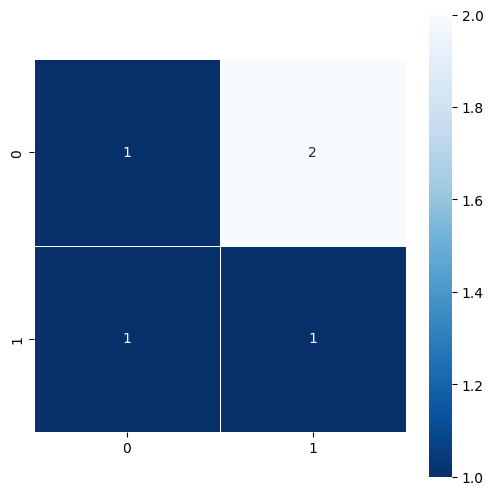

In [157]:
# plot the confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(df_temporal_usuario_test['class'],df_temporal_usuario_test['predict'], labels=[False,True]), annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');

In [158]:
precision_recall_fscore_support(df_temporal_usuario_test['class'],df_temporal_usuario_test['predict'], pos_label=True,average='binary')

(0.3333333333333333, 0.5, 0.4, None)

**Ejercicio: Realice las predicciones binarias para los usuarios en el conjunto de test a los que se les hizo la selección de características, mida la precisión, el recall y f_score de su modelo con las predicciones realizadas y ajústelo cambiando el k**

In [159]:
features_top500 = set()
# 500 usuarios con más ratings en test
unique_users_test = df_conteos_usuario_train_test.nlargest(
    500, 'test_count').index.values
i = 0
print(unique_users_test.shape)
for user in unique_users_test:
    df_temporal_usuario = df_all_interactions_train.loc[df_all_interactions_train.DBbook_userID == user, [
        'DBbook_ItemID', 'class']]

    df_temporal_usuario = df_temporal_usuario.merge(
        df_matriz_tf_idf, how='left', left_on='DBbook_ItemID', right_index=True)

    pesos_chi2, pval = chi2(
        df_temporal_usuario[features], df_temporal_usuario['class'])
    pesos_chi2 = np.nan_to_num(pesos_chi2)
    pesos_chi2_mask = pesos_chi2 > 0
    features_usuario = features[pesos_chi2_mask]
    features_top500 |= set(features_usuario)
    i = i+1
    if i % 50 == 0:
        clear_output()
        display(f"{i} de {len(unique_users_test)}")
del df_temporal_usuario


'500 de 500'

In [196]:
print(f"features_top500: {len(features_top500)}")

features_top500: 3621


In [161]:
feature_list = list(features_top500)
df_temporal_usuarios_train = df_all_interactions_train.loc[df_all_interactions_train.DBbook_userID.isin(unique_users_test), [
    'DBbook_ItemID', 'class']]


In [162]:
df_temporal_usuarios_train = df_temporal_usuarios_train.merge(
    df_matriz_tf_idf[feature_list], how='left', left_on='DBbook_ItemID', right_index=True, suffixes=('', '_y'))
df_temporal_usuarios_train


,DBbook_ItemID,class,1,2,3,4,5,6,7,8,...,8136,8137,8138,8139,8153,8155,8162,8164,8166,8179
63786,7211,False,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46017,5168,True,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1066,7453,False,0.0,0.0,2.146438,2.196319,2.195239,2.149048,2.149048,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37965,4108,False,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1964,7453,True,0.0,0.0,2.146438,2.196319,2.195239,2.149048,2.149048,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29992,1527,True,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8736,2561,False,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66308,8010,False,0.0,0.0,2.146438,2.196319,2.195239,2.149048,2.149048,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33004,1732,False,0.0,0.0,2.146438,2.196319,2.195239,2.149048,2.149048,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [197]:
df_temporal_usuarios_train[df_temporal_usuarios_train["DBbook_ItemID"]==7211]


,DBbook_ItemID,class,1,2,3,4,5,6,7,8,...,8137,8138,8139,8153,8155,8162,8164,8166,8179,predict
63786,7211,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
35746,7211,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
39582,7211,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
44106,7211,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


In [163]:
df_temporal_usuarios_test = df_all_interactions_test.loc[df_all_interactions_test.DBbook_userID.isin(unique_users_test), [
    'DBbook_ItemID', 'class']]
df_temporal_usuarios_test = df_temporal_usuarios_test.merge(
    df_matriz_tf_idf[feature_list], how='left', left_on='DBbook_ItemID', right_index=True)

df_temporal_usuarios_test

,DBbook_ItemID,class,1,2,3,4,5,6,7,8,...,8136,8137,8138,8139,8153,8155,8162,8164,8166,8179
10733,5439,True,0.0,0.0,2.146438,2.196319,2.195239,2.149048,2.149048,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65090,3133,True,0.0,0.0,2.146438,2.196319,2.195239,2.149048,2.149048,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69943,2992,True,0.0,0.0,2.146438,0.000000,0.000000,2.149048,2.149048,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25730,4344,True,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2583,2482,True,0.0,0.0,2.146438,0.000000,0.000000,2.149048,2.149048,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27331,3488,False,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26123,5519,True,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12780,5942,False,0.0,0.0,2.146438,2.196319,2.195239,2.149048,2.149048,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30416,4906,False,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
params = {'knn__n_neighbors': list(range(3, 100))}

knn_clasif = KNeighborsClassifier()

pipe = Pipeline(steps=[('knn', knn_clasif)])

# ojo, de esta forma  tarda un montón, para que no tarde tanto, usar el método comentado, el resultado del gridearch debería dar 35
knn_grid_exh = GridSearchCV(pipe, params, cv=5, scoring=['f1', 'precision', 'recall'], n_jobs=-1, return_train_score=True, refit='f1')
# knn_grid_exh = GridSearchCV(pipe, params, cv=5, scoring="f1", n_jobs=-1)


In [205]:
grid = knn_grid_exh


In [206]:
%%time
grid.fit(df_temporal_usuarios_train[feature_list],
         df_temporal_usuarios_train['class'])


CPU times: total: 2.31 s
Wall time: 20min 42s


GridSearchCV(cv=5, estimator=Pipeline(steps=[('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                              13, 14, 15, 16, 17, 18, 19, 20,
                                              21, 22, 23, 24, 25, 26, 27, 28,
                                              29, 30, 31, 32, ...]},
             refit='f1', return_train_score=True,
             scoring=['f1', 'precision', 'recall'])

In [208]:
models = pd.DataFrame(grid.cv_results_)
models.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,...,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall
0,0.926009,0.118356,5.655380,0.374034,3,{'knn__n_neighbors': 3},0.565574,0.577458,0.561240,0.561114,...,0.584957,0.009088,94,0.710393,0.685630,0.698905,0.695699,0.694096,0.696944,0.008030
1,1.027255,0.107864,5.873175,0.605503,4,{'knn__n_neighbors': 4},0.492966,0.517647,0.502375,0.509758,...,0.450528,0.014371,97,0.535399,0.526175,0.553032,0.538873,0.547689,0.540234,0.009405
2,0.739182,0.025606,5.657205,0.419479,5,{'knn__n_neighbors': 5},0.577871,0.608610,0.587165,0.589756,...,0.623431,0.022558,92,0.687951,0.695513,0.709324,0.708790,0.711996,0.702715,0.009344
3,0.943491,0.172750,5.816067,0.679146,6,{'knn__n_neighbors': 6},0.529584,0.549865,0.533932,0.559081,...,0.522766,0.024126,96,0.539941,0.599092,0.604061,0.604328,0.623297,0.594144,0.028335
4,0.858178,0.136114,5.956047,0.790957,7,{'knn__n_neighbors': 7},0.601215,0.618234,0.594463,0.602700,...,0.662328,0.020150,88,0.676730,0.728365,0.736041,0.722950,0.724552,0.717728,0.020991


In [209]:
models.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_knn__n_neighbors', 'params', 'split0_test_f1', 'split1_test_f1',
       'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1',
       'std_test_f1', 'rank_test_f1', 'split0_train_f1', 'split1_train_f1',
       'split2_train_f1', 'split3_train_f1', 'split4_train_f1',
       'mean_train_f1', 'std_train_f1', 'split0_test_precision',
       'split1_test_precision', 'split2_test_precision',
       'split3_test_precision', 'split4_test_precision', 'mean_test_precision',
       'std_test_precision', 'rank_test_precision', 'split0_train_precision',
       'split1_train_precision', 'split2_train_precision',
       'split3_train_precision', 'split4_train_precision',
       'mean_train_precision', 'std_train_precision', 'split0_test_recall',
       'split1_test_recall', 'split2_test_recall', 'split3_test_recall',
       'split4_test_recall', 'mean_test_recall', 'std_test_recall',
       'rank

In [211]:
list(filter(lambda x: x.startswith('mean_test'), models.columns))

['mean_test_f1', 'mean_test_precision', 'mean_test_recall']

In [212]:
models["F1_percent"] = models["mean_test_f1"]*100
models["Precision_percent"] = models["mean_test_precision"]*100
models["Recall_percent"] = models["mean_test_recall"]*100
models.sort_values(by="param_knn__n_neighbors", ascending=False, inplace=True)
models.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,...,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall,F1_percent,Precision_percent,Recall_percent
96,0.864056,0.152157,6.176905,0.729675,99,{'knn__n_neighbors': 99},0.428277,0.623912,0.670538,0.606318,...,0.386588,0.749733,0.935346,0.755009,0.926530,0.750641,0.198800,59.990866,54.712842,72.173683
95,0.912728,0.142077,6.032146,0.532794,98,{'knn__n_neighbors': 98},0.381227,0.605660,0.665623,0.598240,...,0.323270,0.714476,0.925461,0.716538,0.920118,0.719973,0.218951,58.451191,54.641709,69.224073
94,0.855104,0.166478,6.300816,0.584815,97,{'knn__n_neighbors': 97},0.413602,0.629529,0.665377,0.610824,...,0.360673,0.763088,0.932941,0.758750,0.930003,0.749091,0.208656,59.745406,54.460294,72.174002


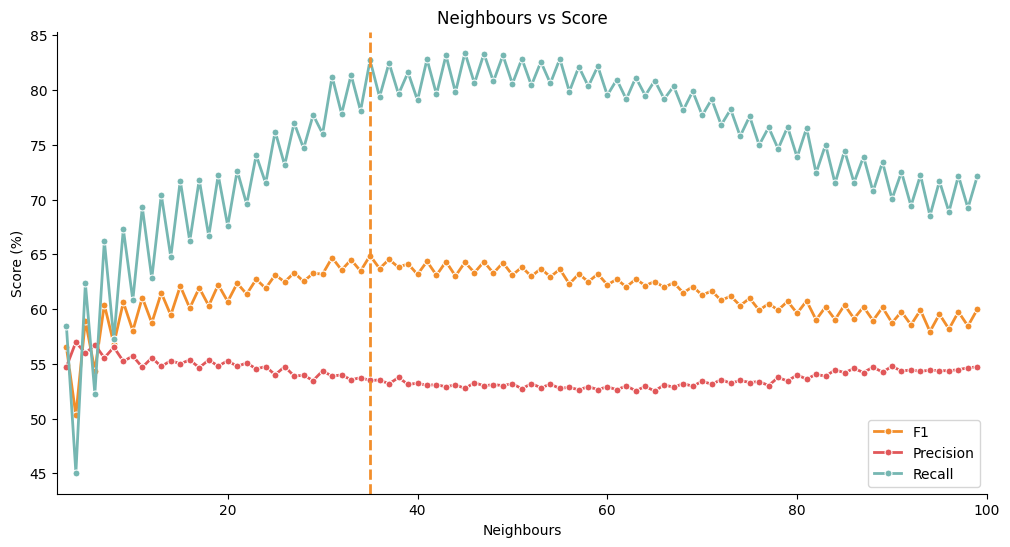

In [217]:
# plot neighbors vs F1
plt.figure(figsize=(12,6))

f1_color = '#F28E2B'
precision_color = '#E15759'
recall_color = '#76B7B2'
sns.lineplot(x='param_knn__n_neighbors', y='F1_percent',
             data=models, marker='o', markersize=5, linewidth=2, color=f1_color, label='F1')
sns.lineplot(x='param_knn__n_neighbors', y='Precision_percent',
                data=models, marker='o', markersize=5, linewidth=2,color=precision_color, label='Precision')
sns.lineplot(x='param_knn__n_neighbors', y='Recall_percent',
                data=models, marker='o', markersize=5, linewidth=2,color=recall_color, label='Recall')
plt.legend(loc='lower right')
plt.xlim(2, 100)
plt.xlabel('Neighbours')
plt.ylabel('Score (%)')
plt.title('Neighbours vs Score')
sns.despine()
# color the best F1
plt.axvline(x=grid.best_params_['knn__n_neighbors'], color=f1_color, linestyle='--', linewidth=2, label='Best F1')

plt.show()

In [218]:
grid.best_params_

{'knn__n_neighbors': 35}

In [219]:
best_knn = grid.best_estimator_


In [220]:
df_temporal_usuarios_test['predict']=best_knn.predict(df_temporal_usuarios_test[feature_list])

In [221]:
df_temporal_usuarios_train['predict'] = best_knn.predict(df_temporal_usuarios_train[feature_list])

In [222]:
df_temporal_usuarios_test[['DBbook_ItemID','class','predict']].merge(df_libros, how='left', on='DBbook_ItemID')
df_temporal_usuarios_train[['DBbook_ItemID','class','predict']].merge(df_libros, how='left', on='DBbook_ItemID')

,DBbook_ItemID,class,predict,name
0,7211,False,True,First Meetings
1,5168,True,True,"Cry, the Beloved Country"
2,7453,False,False,The Undomestic Goddess
3,4108,False,True,"So Long, and Thanks for All the Fish"
4,7453,True,False,The Undomestic Goddess
...,...,...,...,...
9136,1527,True,True,"Compilers: Principles, Techniques, and Tools"
9137,2561,False,True,Snow Flower and the Secret Fan
9138,8010,False,False,The Catcher in the Rye
9139,1732,False,False,The Dragon Reborn


In [223]:
tn, fp, fn, tp = confusion_matrix(
    df_temporal_usuarios_train['class'], df_temporal_usuarios_train['predict'], labels=[False, True]).ravel()

(tn, fp, fn, tp)
display(Markdown(
    f"### Resultados con entrenamiento\n\n||**True real**|**False real**|\n|:---:|:---:|:---:|\n|**True predicted**|{tp}|{fp}|\n|**False predicted**|{fn}|{tn}|"))


### Resultados con entrenamiento

||**True real**|**False real**|
|:---:|:---:|:---:|
|**True predicted**|3780|3079|
|**False predicted**|899|1383|

In [224]:
tn_t, fp_t, fn_t, tp_t = confusion_matrix(
    df_temporal_usuarios_test['class'], df_temporal_usuarios_test['predict'], labels=[False, True]).ravel()

(tn_t, fp_t, fn_t, tp_t)
display(Markdown(f"### Resultados con test\n\n||**True real**|**False real**|\n|:---:|:---:|:---:|\n|**True predicted**|{tp_t}|{fp_t}|\n|**False predicted**|{fn_t}|{tn_t}|"))

### Resultados con test

||**True real**|**False real**|
|:---:|:---:|:---:|
|**True predicted**|1001|868|
|**False predicted**|242|299|

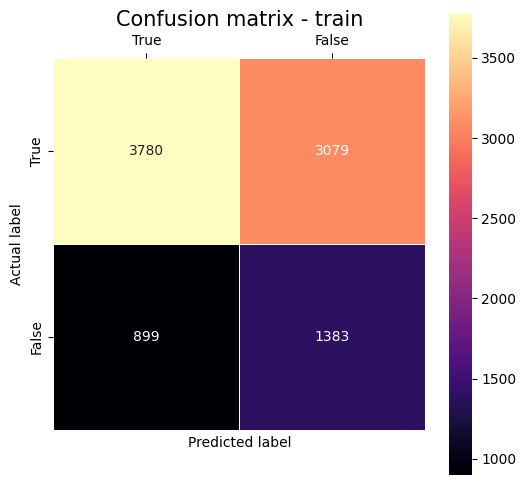

In [225]:
plt.figure(figsize=(6, 6))
sns.heatmap([[tp, fp], [fn, tn]], annot=True, fmt="d", linewidths=.5, square=True,
            xticklabels=['True', 'False'], yticklabels=['True', 'False'], cmap='magma',)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix - train', size=15)
plt.gca().xaxis.tick_top()
plt.show()


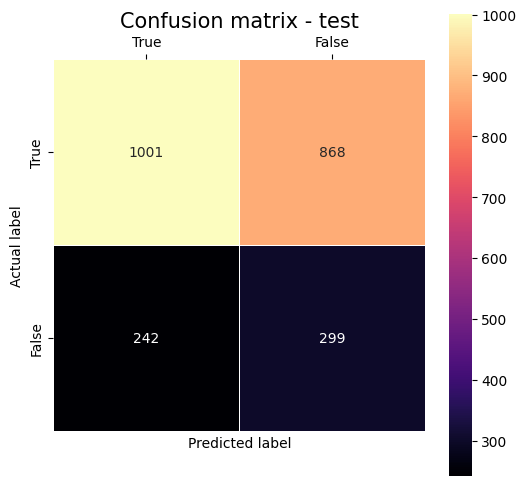

In [226]:
plt.figure(figsize=(6,6))
sns.heatmap([[tp_t,fp_t],[fn_t,tn_t]], annot=True, fmt="d", linewidths=.5, square = True,xticklabels=['True','False'], yticklabels=['True','False'], cmap = 'magma',)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix - test', size = 15)
plt.gca().xaxis.tick_top()
plt.show()

In [227]:
prec_recall_scores_train = precision_recall_fscore_support(
    df_temporal_usuarios_train['class'], df_temporal_usuarios_train['predict'], pos_label=True, average='binary')
precision = prec_recall_scores_train[0]*100
recall = prec_recall_scores_train[1]*100
f1 = prec_recall_scores_train[2]*100
support = df_temporal_usuarios_train['predict'].value_counts()[0]


prec_recall_scores_test = precision_recall_fscore_support(
    df_temporal_usuarios_test['class'], df_temporal_usuarios_test['predict'], pos_label=True, average='binary')
precision_t = prec_recall_scores_test[0]*100
recall_t = prec_recall_scores_test[1]*100
f1_t = prec_recall_scores_test[2]*100
support_t = df_temporal_usuarios_test['predict'].value_counts()[0]

display(Markdown(
    f"### Resultados con entrenamiento\n\n||**Precision**|**Recall**|**F1**|**Support**|\n|:---:|:---:|:---:|:---:|:---:|\n|**Train**|{precision:.3f}%|{recall:.3f}%|{f1:.3f}%|{0 if support is None else support:d}|\n|**Test**|{precision_t:.3f}%|{recall_t:.3f}%|{f1_t:.3f}%|{0 if support_t is None else support_t:d}|"))



### Resultados con entrenamiento

||**Precision**|**Recall**|**F1**|**Support**|
|:---:|:---:|:---:|:---:|:---:|
|**Train**|55.110%|80.786%|65.523%|6859|
|**Test**|53.558%|80.531%|64.332%|1869|